In [3]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from fredapi import Fred
from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from class_model.model_prep import ModelPrep
from core.system import *
from core.operation import *
from class_trend.trend_helper import TrendHelper

import warnings

warnings.filterwarnings('ignore')

# Functions

In [4]:
#Reads in all the results in the "modelName" folder
def read_result(model_name, result_name):
    data = []
    result_data_dir = get_ml_result_model(live, model_name)
    for i, folder_name in enumerate(os.listdir(result_data_dir)):
        try:
            if folder_name.startswith("params"):
                folder_path = os.path.join(result_data_dir, folder_name)
                file_path = os.path.join(folder_path, f"{result_name}.parquet.brotli")
                print(os.path.basename(folder_path))
                data.append(pd.read_parquet(file_path))
        except:
            continue
    return pd.concat(data, axis=0).reset_index(drop=True)

#Calculates the product of the daily_ic_mean and maximum overall IC in each result to find the best performing model
def get_max_ic(data):
    collection={}
    for index, row in data.iterrows():
        collection[max(row.loc[(row.index.str.startswith("daily_metric"))])]=index
    max_ic_idx=collection[max(list(collection.keys()))]
    return data.iloc[max_ic_idx]

#Gets the files of the best performing model
def get_max_ic_file(data, model_name):
    files = {}
    time_index = data.to_frame().index.get_loc('time')
    param_vals = data.iloc[:time_index].values
    key = [f'{float(p)}' for p in (param_vals)]
    key = '_'.join(key)
    
    result_data_dir = get_ml_result_model(live, model_name) / f'params_{key}'
    for file in os.listdir(result_data_dir):
        if file.endswith(".parquet.brotli"):
            files[extract_first_string(file)]=pd.read_parquet(os.path.join(result_data_dir, file))
        elif file.endswith(".png"):
            img = os.path.join(result_data_dir, file)
            files[extract_first_string(file)]=Image(img)
    return files

def get_all(model_name):
    return get_max_ic_file(get_max_ic(read_result(model_name, 'metrics')), model_name)

def sign_accuracy(predictions, actual, target_sign, pred):
    accuracies = []  # To store accuracies for each ticker
    
    # Iterate through each ticker and calculate accuracy
    for ticker in predictions.index.levels[0]:
        ticker_group = predictions.loc[ticker]
        actual_group = actual.loc[ticker]
        
        # Determine if each pair has the same sign
        if pred == 'price':
            correct_signs = (np.sign(ticker_group) == np.sign(actual_group))
        elif pred == 'sign':
            ticker_group = np.where(ticker_group > 0.5, 1, -1)
            correct_signs = (ticker_group == np.sign(actual_group))
            
        # Filter by target sign if specified
        if target_sign == 'positive':
            mask = (np.sign(actual_group) == 1)
            correct_signs = correct_signs[mask]
        elif target_sign == 'negative':
            mask = (np.sign(actual_group) == -1)
            correct_signs = correct_signs[mask]
        
        # Calculate the accuracy and store it
        accuracy = np.mean(correct_signs) * 100  # Convert to percentage
        accuracies.append(accuracy)
        
    # Calculate and return the mean accuracy across all tickers
    mean_accuracy = np.nanmean(accuracies)
    return mean_accuracy

In [5]:
def price(best_model_params, dir_path, iteration, plot):
    #Gets the predictions of the highest overall IC in the boosted round cases
    if iteration == False:
        best_prediction=best_model_params['predictions'][[str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("daily_metric")].idxmax(axis=1)[0])), 'i']]
    else:
        best_prediction=best_model_params['predictions'][[str(iteration), 'i']]
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'window', 'returns']
    merged.window = merged.window.astype(int)
    #Shift actual returns 1 day back
    merged['returns'] = merged.groupby('permno')['returns'].shift(-1)
    merged = merged.dropna()

    if plot == False:
        return merged
        
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%")
    display(best_model_params['metrics'])
    
    # Convert to HTML
    df_html = best_model_params['metrics'].to_html(classes='my-table')

    # Prepare the plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    best_model_params['daily_metric'][best_prediction.columns[0]].rolling(window=42).mean().plot(
        ax=ax, linewidth=0.5, color='blue', linestyle='-', title='Daily Metric Plot'
    )
    ax.set(xlabel='Date', ylabel='Daily Metric')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Convert plot to SVG
    img_stream = BytesIO()
    fig.savefig(img_stream, format='png')
    img_base64 = base64.b64encode(img_stream.getvalue()).decode()

    with open(dir_path / 'metric.html', 'w') as f:
        f.write('''<!DOCTYPE html>
        <html lang="en">
        <head>
        <meta charset="UTF-8">
        <title>Metrics Report</title>
        <style>
            body {
                font-family: 'Times New Roman', serif;
                margin: 0;
                padding: 0;
                background-color: #ffffff;
                text-align: center;
                color: #000000;
            }
            header {
                background: #d3d3d3;
                color: #000000;
                text-align: center;
                padding-top: 30px;
                min-height: 70px;
                margin: 0 auto;
            }
            .container {
                width: 70%;
                margin: auto;
            }
            .main-content {
                padding: 30px;
            }
            .my-table {
                width: 100%; 
                border-collapse: collapse;
                font-size: 12px;
                table-layout: fixed; 
            }
            th, td {
                border: 2px solid #e3e3e3;
                padding: 10px;
                text-align: left;
                word-wrap: break-word;
            }
        </style>
        </head>
        <body>
            <header>
                <h1>Metrics Report</h1>
            </header>
            <div class="container">
                <div class="main-content">
                    <p>Best num_iterations: ''' + str(best_prediction.columns[0]) + '''</p>
                    <p>Neutral Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%" + '''</p>
                    <p>Positive Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%" + '''</p>
                    <p>Negative Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%" + '''</p>
                    ''' + df_html + '''
                    <img src="data:image/png;base64,''' + img_base64 + '''" alt="plot" />
                </div>
            </div>
        </body>
        </html>''')
    return merged

def plot_ensemble(merged, ic_by_day):
    print(f'Daily IC Mean: {round(ic_by_day.mean()[0], 5)}')
    # Prepare the plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    ic_by_day.rolling(window=42).mean().plot(ax=ax, linewidth=0.5, color='blue', linestyle='-', title='Daily Metric Plot')
    ax.set(xlabel='Date', ylabel='Daily Metric')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    # Convert plot to SVG
    img_stream = BytesIO()
    fig.savefig(img_stream, format='png')
    img_base64 = base64.b64encode(img_stream.getvalue()).decode()
    
    with open(dir_path / 'metric.html', 'w') as f:
        f.write('''<!DOCTYPE html>
        <html lang="en">
        <head>
        <meta charset="UTF-8">
        <title>Metrics Report</title>
        <style>
            body {
                font-family: 'Times New Roman', serif;
                margin: 0;
                padding: 0;
                background-color: #ffffff;
                text-align: center;
                color: #000000;
            }
            header {
                background: #d3d3d3;
                color: #000000;
                text-align: center;
                padding-top: 30px;
                min-height: 70px;
                margin: 0 auto;
            }
            .container {
                display: flex;
                justify-content: center;
                align-items: center;
                flex-direction: column;
            }
            .main-content {
                padding: 30px;
            }
            .my-table {
                width: 100%; 
                border-collapse: collapse;
                font-size: 12px;
                table-layout: fixed; 
            }
            th, td {
                border: 2px solid #e3e3e3;
                padding: 10px;
                text-align: left;
                word-wrap: break-word;
            }
        </style>
        </head>
        <body>
            <header>
                <h1>Metrics Report</h1>
            </header>
            <div class="container">
                <div class="main-content">
                    <p>Neutral Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%" + '''</p>
                    <p>Positive Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%" + '''</p>
                    <p>Negative Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%" + '''</p>
                    <img src="data:image/png;base64,''' + img_base64 + '''" alt="plot" />
                </div>
            </div>
        </body>
        </html>''')

def sign(best_model_params):
    #Gets the predictions of the highest overall IC in the boosted round cases
    best_prediction=best_model_params['predictions'][str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("daily_metric")].idxmax(axis=1)[0]))].to_frame()
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'returns']
    #Shift actual returns 1 day back
    merged['returns'] = merged.groupby('permno')['returns'].shift(-1)
    merged = merged.dropna()
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'sign'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'sign'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'sign'), 2)}%")
    display(best_model_params['metrics'])
    return merged

def gain(gain):
    # Sort by mean gain in descending order
    sorted_df = gain.sort_values(by='mean', ascending=False)

    # Plot
    plt.figure(figsize=(15, 50))
    sorted_df['mean'].plot(kind='barh')
    plt.xlabel('Average Gain')
    plt.ylabel('Features')
    plt.title('Feature Importances based on Gain')
    plt.gca().invert_yaxis()  # to have the most important feature on top
    plt.tight_layout()
    plt.show()
    
def split(split):
    # Sort by mean gain in descending order
    sorted_df = split.sort_values(by='mean', ascending=False)

    # Plot
    plt.figure(figsize=(15, 50))
    sorted_df['mean'].plot(kind='barh')
    plt.xlabel('Average Split')
    plt.ylabel('Features')
    plt.title('Feature Importances based on Split')
    plt.gca().invert_yaxis()  # to have the most important feature on top
    plt.tight_layout()
    plt.show()

In [6]:
def hrp(returns, stocks, date):
    def correl_dist(corr):
        # A distance matrix based on correlation, where 0<=d[i,j]<=1
        # This is a proper distance metric
        dist = ((1 - corr) / 2.)**.5  # distance matrix
        dist = squareform(dist)
        return dist

    def get_quasi_diag(link):
        # Sort clustered items by distance
        link = link.astype(int)
        sortIx = pd.Series([link[-1, 0], link[-1, 1]])
        numItems = link[-1, 3]  # number of original items
        while sortIx.max() >= numItems:
            sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
            df0 = sortIx[sortIx >= numItems]  # find clusters
            i = df0.index
            j = df0.values - numItems
            sortIx[i] = link[j, 0]  # item 1
            df1 = pd.Series(link[j, 1], index=(i + 1).tolist())
            sortIx = pd.concat([sortIx, df1]).sort_index()
            sortIx.index = range(sortIx.shape[0])
        return sortIx.tolist()

    def get_cluster_var(cov, cItems):
        # Compute variance per cluster
        cov_= cov.loc[cItems,cItems] # matrix slice
        # Compute the inverse_variance portfolio
        ivp = 1. / np.diag(cov_)
        ivp /= ivp.sum()
        w_= ivp.reshape(-1,1)
        cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
        return cVar

    def get_rec_bipart(cov, sortIx):
        # Compute HRP alloc
        w = pd.Series(1, index=sortIx)
        cItems = [sortIx]  # initialize all items in one cluster
        while len(cItems) > 0:
            cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
            for i in range(0, len(cItems), 2):  # parse in pairs
                cItems0 = cItems[i]  # cluster 1
                cItems1 = cItems[i + 1]  # cluster 2
                cVar0 = get_cluster_var(cov, cItems0)
                cVar1 = get_cluster_var(cov, cItems1)
                alpha = 1 - cVar0 / (cVar0 + cVar1)
                w[cItems0] *= alpha  # weight 1
                w[cItems1] *= 1 - alpha  # weight 2
        return w
    
    cov, corr = returns.cov(), returns.corr()
    # Construct a hierarchical portfolio
    dist = correl_dist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = get_quasi_diag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = get_rec_bipart(cov, sortIx)
    return hrp.sort_index().values

def ivp(returns, stocks, date):
    # Compute the inverse-variance portfolio
    cov = returns.cov()
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ewp(returns, stocks, date, leverage):
    weight = leverage/len(returns.columns)
    return np.full(len(returns.columns), weight)

def mvp(returns, stocks, date):
    cov = returns.cov()
    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(list(wt))

# Minimize Factor Loading Optimization
def mfl(data, type, sb, factor_weights):
    def objective_cvxpy(weights, betas, factor_weights):
        # Initialize the alternative objective
        alternative_objective = 0.0
    
        # Loop through each factor and calculate its contribution to the objective
        for factor, weight in factor_weights.items():
            port_beta = cp.matmul(weights, betas[factor])
            alternative_objective += weight * cp.square(port_beta)
    
        return alternative_objective
        
    collect_weight = []
    count = 0 
    print(f'Processing {type}...')
    for date, row in data.iterrows():
        # Get betas for given stocks at day t
        betas = sb.loc[sb.index.get_level_values(1) == date]
        stocks = row[type]
        betas = get_stocks_data(betas, stocks)
        betas = betas.fillna(0)

        # CVXPY setup
        weights = cp.Variable(betas.shape[0])
        objective = cp.Minimize(objective_cvxpy(weights, betas, factor_weights))
        constraints = [cp.sum(weights) == 1, weights >= 0, weights <= 1]
        prob = cp.Problem(objective, constraints)
        
        # Solve the problem
        # prob.solve()
        prob.solve(solver='ECOS')
        collect_weight.append(weights.value)
        
        # Track performance
        if count % 30 == 0:
            print(date)
        count += 1
    
    return collect_weight

In [7]:
def process_period(period, period_returns, num_stocks, candidates, threshold):
    # Find sp500 candidates for the given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year
    # sp500 = candidates[period_year]
    # tickers = common_stocks(sp500, period)
    # sp500_period = get_stocks_data(period, tickers)
    print("----------------------------------------------")
    print(period_year)
    # print('Num of tickers: ' + str(len(tickers)))

    # Filter the DataFrame to only include rows with market cap over the threshold
    filtered_period = period[period['market_cap'] > threshold]
        
    # Group by date and compute long and short stocks and their returns
    for date, stocks in filtered_period.groupby('date'):
        sorted_stocks = stocks.sort_values(by='predictions')
        long_stocks = sorted_stocks.index.get_level_values('ticker')[-num_stocks:]
        short_stocks = sorted_stocks.index.get_level_values('ticker')[:num_stocks]
        
        # Store results in period_returns DataFrame
        period_returns.loc[date] = [long_stocks.tolist(), sorted_stocks.iloc[-num_stocks:].returns.values,
                                    short_stocks.tolist(), sorted_stocks.iloc[:num_stocks].returns.values]

def backtest(data, num_stocks, threshold):
    global live
    # Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    
    # Get candidates
    candidates = get_candidate(live)
    
    # Loop over each group in tic.groupby('window')
    for _, df in tic.groupby('window'):
        df = df.reset_index().set_index(['ticker', 'date']).drop('window', axis=1)
        process_period(df, period_returns, num_stocks, candidates, threshold)
    
    return period_returns

def plot_hist(data, date):
    pred = data.predictions.loc[data.index.get_level_values('date')==date]
    ret = data.returns.loc[data.index.get_level_values('date')==date]
    plt.hist(pred, bins='auto', edgecolor='black', alpha=0.5, label=f"Pred: {date}")
    plt.hist(ret, bins='auto', edgecolor='red', alpha=0.5, label=f"Real: {date}")
    plt.title('Histogram of values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [8]:
def sharpe_ret(best_model_params, iteration):
    #Gets the predictions of the highest overall IC in the boosted round cases
    if iteration == False:
        best_prediction=best_model_params['predictions'][[str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("daily_metric")].idxmax(axis=1)[0])), 'i']]
    else:
        best_prediction=best_model_params['predictions'][[str(iteration), 'i']]
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'window', 'returns']
    merged.window = merged.window.astype(int)
    #Shift actual returns 1 day back
    merged['returns'] = merged.groupby('permno')['returns'].shift(-1)
    merged = merged.dropna()
    return merged

def sharpe_process_period(period, period_returns, num_stocks, candidates, threshold):
    # Find sp500 candidates for the given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year
    # sp500 = candidates[period_year]
    # tickers = common_stocks(sp500, period)
    # sp500_period = get_stocks_data(period, tickers)

    # Filter the DataFrame to only include rows with market cap over the threshold
    filtered_period = period[period['market_cap'] > threshold]

    # Group by date and compute long and short stocks and their returns
    for date, stocks in filtered_period.groupby('date'):
        sorted_stocks = stocks.sort_values(by='predictions')
        long_stocks = sorted_stocks.index.get_level_values('ticker')[-num_stocks:]
        short_stocks = sorted_stocks.index.get_level_values('ticker')[:num_stocks]
        
        # Store results in period_returns DataFrame
        period_returns.loc[date] = [long_stocks.tolist(), sorted_stocks.iloc[-num_stocks:].returns.values,
                                    short_stocks.tolist(), sorted_stocks.iloc[:num_stocks].returns.values]


def sharpe_backtest(data, num_stocks, threshold):
    global live
    # Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    
    # Get candidates
    candidates = get_candidate(live)
    
    # Loop over each group in tic.groupby('window')
    for _, df in tic.groupby('window'):
        df = df.reset_index().set_index(['ticker', 'date']).drop('window', axis=1)
        sharpe_process_period(df, period_returns, num_stocks, candidates, threshold)
    
    return period_returns

In [9]:
def port_opt(data, window_size, port_opt_func, option, leverage, file=None, factor_weights=None, factor_cols=None):
    global live
    assert port_opt_func==ewp or port_opt_func==hrp or port_opt_func==mvp or port_opt_func==ivp or port_opt_func==mfl, 'Must use callable function ewp, hrp, mvp, ivp, or mfl'
    if port_opt_func==hrp or port_opt_func==mvp or port_opt_func==ivp or port_opt_func==mfl:
        assert window_size>0, 'Window size must be greater than 0 if using hrp, mvp, ivp, or mfl'
    @ray.remote
    def exec_port_opt(i, data, window_size, port_opt_func, option):
        if option == 'long':  
            # Get window data for long returns
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_stocks = data['longStocks'][i:i+window_size][-1]
            date = data.iloc[i:i+window_size].index[-1]
            # Perform desired portfolio optimization
            long_weights = port_opt_func(long_returns, long_stocks, date)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights)
        elif option == 'short':
            # Get window data for short returns
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_stocks = data['shortStocks'][i:i+window_size][-1]
            date = data.iloc[i:i+window_size].index[-1]
            # Perform desired portfolio optimization
            short_weights = port_opt_func(short_returns, short_stocks, date)
            total_ret = np.sum(short_returns.iloc[-1] * short_weights)
        elif option == 'both':
            # Get window data for long returns and short returns
            # Perform desired portfolio optimization
            date = data.iloc[i:i+window_size].index[-1]
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_stocks = data['longStocks'][i:i+window_size][-1]
            long_weights = port_opt_func(long_returns, long_stocks, date)
            
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_stocks = data['shortStocks'][i:i+window_size][-1]
            short_weights = port_opt_func(short_returns, short_stocks, date)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights) + np.sum(short_returns.iloc[-1] * short_weights)
            
        return total_ret
    
    if port_opt_func == ewp:
        if option == 'long':
            # Get long returns
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns, None, None, leverage)

            # Calculate equal-weights and sum up to get total strategy return
            long_weights = np.tile(long_weights, (len(long_returns), 1))
            total_ret = np.sum(long_returns.values * long_weights, axis=1)
        elif option == 'short':
            # Get short returns
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns, None, None, leverage)

            # Calculate equal-weights and sum up to get total strategy return
            short_weights = np.tile(short_weights, (len(short_returns), 1))
            total_ret = np.sum(short_returns.values * short_weights, axis=1)
        elif option == 'both':
            # Get long returns
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns, None, None, leverage)
            long_weights = np.tile(long_weights, (len(long_returns), 1))

            # Get short returns
            short_returns = -1 * pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns, None, None, leverage)
            short_weights = np.tile(short_weights, (len(short_returns), 1))

            # Calculate equal-weights and sum up to get total strategy return
            total_ret = np.sum(long_returns.values * long_weights, axis=1) + np.sum(short_returns.values * short_weights, axis=1)
        data['totalRet'] = total_ret
        return data

    if port_opt_func == mfl:
        # Read in calculate betas and convert from permno to ticker index
        stock = read_stock(get_load_data_large_dir() / 'permno_to_train_fund.csv')
        sb = ModelPrep(factor_name=file, group='permno', interval='D', kind='price', stock=stock, div=False, start='2006-01-01', end='2023-01-01', save=False).prep()
        ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')
        sb = sb.merge(ticker, left_index=True, right_index=True, how='left')
        sb = sb.reset_index().set_index(['ticker', 'date'])
        sb = sb.sort_index(level=['ticker', 'date'])
        sb = sb.drop('permno', axis=1)
        sb = sb[factor_cols]
        # For some reason, reseting index and setting it to ticker, date creates duplicate indices (should probably check this out)
        sb = sb[~sb.index.duplicated(keep='first')]
        
        if option == 'long':
            # Calculate minimized-factor loading weights and sum it up to get strategy return
            long_weights = mfl(data, 'longStocks', sb, factor_weights)
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights_df = pd.DataFrame(long_weights)
            total_ret = np.sum(long_returns.values * long_weights_df.values, axis=1)
        elif option == 'short':
            # Calculate minimized-factor loading weights and sum it up to get strategy return
            short_weights = mfl(data, 'shortStocks', sb, factor_weights)
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())
            short_weights_df = pd.DataFrame(short_weights)
            total_ret = np.sum(short_returns.values * short_weights_df.values, axis=1)
        elif option == 'both':
            # Get long returns
            long_weights = mfl(data, 'longStocks', sb, factor_weights)
            long_returns = pd.DataFrame(data['longRet'].tolist())

            # Get short returns
            short_weights = mfl(data, 'shortStocks', sb, factor_weights)
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())

            # Calculate minimized-factor loading weights and sum it up to get strategy return
            long_weights_df = pd.DataFrame(long_weights)
            short_weights_df = pd.DataFrame(short_weights)
            total_ret = np.sum(long_returns.values * long_weights_df.values, axis=1) + np.sum(short_returns.values * short_weights_df.values, axis=1)
        data['totalRet'] = total_ret
        return data
        
    ray.init(num_cpus=16, ignore_reinit_error=True)
    start_time = time.time()
    total_ret_collect = ray.get([exec_port_opt.remote(i, data, window_size, port_opt_func, option) for i in range(0, len(data) - window_size + 1)])
    end_time = time.time()
    elapsed_time = end_time - start_time
    rounded_time = round(elapsed_time, 2)
    print(f"Elapsed time: {rounded_time} seconds")
    ray.shutdown()
    
    data = data[window_size-1:]
    data['totalRet'] = total_ret_collect
    return data 

# Read in Results

In [10]:
live = False
trial = 'lightgbm_trial_106'
files = read_result(trial, 'metrics')

params_6.0_0.15_15.0_1.0_0.02_60.0_0.0_0.01_0.5_1.0


In [274]:
live = True
format_end = date.today().strftime('%Y%m%d')
format_end = '20240319'
trial = f'lightgbm_{format_end}'
files = read_result(trial, 'metrics')

params_4.0_0.11_32.0_1.0_0.02_144.0_0.0_5.9e-05_1.0_0.0
params_4.0_0.11_68.0_1.0_0.02_108.0_0.0_7.3e-05_1.0_0.0
params_4.0_0.14_115.0_1.0_0.02_59.0_0.0_4.5e-05_1.0_0.0


In [277]:
live = True
format_end = date.today().strftime('%Y%m%d')
trial = f'lightgbm_{format_end}'
files = read_result(trial, 'metrics')

params_4.0_0.11_105.0_1.0_0.02_168.0_0.0_0.043_1.0_0.0
params_4.0_0.11_24.0_1.0_0.02_76.0_0.0_0.65_1.0_0.0
params_4.0_0.11_70.0_1.0_0.02_187.0_0.0_0.0044_1.0_0.0
params_4.0_0.11_95.0_1.0_0.02_69.0_0.0_0.041_1.0_0.0
params_4.0_0.12_113.0_1.0_0.02_90.0_0.0_0.18_1.0_0.0
params_4.0_0.12_137.0_1.0_0.02_129.0_0.0_0.24_1.0_0.0
params_4.0_0.12_55.0_1.0_0.02_152.0_0.0_0.00028_1.0_0.0
params_4.0_0.13_84.0_1.0_0.02_126.0_0.0_0.093_1.0_0.0
params_4.0_0.14_60.0_1.0_0.02_111.0_0.0_2.9_1.0_0.0
params_4.0_0.15_125.0_1.0_0.02_142.0_0.0_5.3_1.0_0.0
params_4.0_0.15_71.0_1.0_0.02_139.0_0.0_4.9e-05_1.0_0.0
params_4.0_0.15_83.0_1.0_0.02_165.0_0.0_0.00074_1.0_0.0
params_4.0_0.15_99.0_1.0_0.02_188.0_0.0_0.54_1.0_0.0
params_4.0_0.16_122.0_1.0_0.02_151.0_0.0_0.36_1.0_0.0
params_4.0_0.16_36.0_1.0_0.02_88.0_0.0_0.00078_1.0_0.0
params_4.0_0.17_55.0_1.0_0.02_149.0_0.0_1.5_1.0_0.0
params_4.0_0.17_55.0_1.0_0.02_157.0_0.0_0.0097_1.0_0.0
params_4.0_0.18_82.0_1.0_0.02_180.0_0.0_0.0083_1.0_0.0
params_4.0_0.18_92.0_1.0_0.

In [260]:
live = True
format_end = date.today().strftime('%Y%m%d')
trial = f'lightgbm_trial_2305'
files = read_result(trial, 'metrics')

params_4.0_0.14_115.0_1.0_0.02_59.0_0.0_4.5e-05_1.0_0.0


In [310]:
keep = {}
ticker = pd.read_parquet(get_parquet(live) / 'data_ticker.parquet.brotli')
misc = pd.read_parquet(get_parquet(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
for i, row in files.iterrows():
    read_file = get_max_ic_file(row, trial)
    returns = sharpe_ret(read_file, iteration=False)
    # Convert Permno to Ticker
    tic = returns.merge(ticker, left_index=True, right_index=True, how='left')
    tic = tic.merge(misc, left_index=True, right_index=True, how='left')
    tic = tic.reset_index().set_index(['window', 'ticker', 'date'])
    tic = tic.drop('permno', axis=1)
    pred = sharpe_backtest(tic, num_stocks=20, threshold=2_000_000_000)
    equal_weight = port_opt(data=pred, window_size=21, port_opt_func=ewp, option='both', leverage=0.5)
    stock = equal_weight['totalRet']
    sharpe = qs.stats.sharpe(stock)
    calmar = qs.stats.calmar(stock)
    print('-' * 60)
    print(f'Row: {i}')
    display(read_file['metrics'])
    print(f'SHARPE Ratio: {sharpe}')
    print(f'CALMAR Ratio: {calmar}')
    # keep[i] = np.mean(sharpe+calmar)
    keep[i] = np.mean([sharpe,calmar])

------------------------------------------------------------
Row: 0


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.11,105.0,1.0,0.02,168.0,0.0,0.043,1.0,0.0,...,0.015443,0.018943,0.018673,0.01795,0.019087,0.019756,0.015155,0.011271,0.012966,0.013848


SHARPE Ratio: 2.5289759062627923
CALMAR Ratio: 1.6666984033892316
------------------------------------------------------------
Row: 1


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.11,24.0,1.0,0.02,76.0,0.0,0.65,1.0,0.0,...,0.013369,0.01492,0.014865,0.015289,0.016167,0.017377,0.014747,0.010945,0.011576,0.012209


SHARPE Ratio: 2.247755965067285
CALMAR Ratio: 1.897849461645312
------------------------------------------------------------
Row: 2


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.11,70.0,1.0,0.02,187.0,0.0,0.0044,1.0,0.0,...,0.013945,0.018826,0.018254,0.018346,0.019791,0.019313,0.016008,0.012351,0.0142,0.015575


SHARPE Ratio: 2.7213241311581347
CALMAR Ratio: 3.5019718362918226
------------------------------------------------------------
Row: 3


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.11,95.0,1.0,0.02,69.0,0.0,0.041,1.0,0.0,...,0.014707,0.016307,0.016599,0.017088,0.01786,0.017569,0.013952,0.010719,0.011762,0.012247


SHARPE Ratio: 2.8713317423498186
CALMAR Ratio: 3.2376647855506846
------------------------------------------------------------
Row: 4


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.12,113.0,1.0,0.02,90.0,0.0,0.18,1.0,0.0,...,0.012614,0.01441,0.014146,0.013271,0.015698,0.013629,0.010142,0.010842,0.011288,0.012438


SHARPE Ratio: 2.488491176261693
CALMAR Ratio: 2.953861481775081
------------------------------------------------------------
Row: 5


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.12,137.0,1.0,0.02,129.0,0.0,0.24,1.0,0.0,...,0.016983,0.016986,0.016572,0.017708,0.018596,0.015447,0.011387,0.012706,0.012542,0.013733


SHARPE Ratio: 2.7909409415810154
CALMAR Ratio: 3.187781906115781
------------------------------------------------------------
Row: 6


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.13,84.0,1.0,0.02,126.0,0.0,0.093,1.0,0.0,...,0.016444,0.017548,0.015931,0.017434,0.018448,0.013898,0.009576,0.01114,0.012611,0.012707


SHARPE Ratio: 2.3161793551397527
CALMAR Ratio: 2.4545765778255424
------------------------------------------------------------
Row: 7


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.14,60.0,1.0,0.02,111.0,0.0,2.9,1.0,0.0,...,0.014237,0.015771,0.014275,0.016225,0.017257,0.012666,0.012532,0.01392,0.013986,0.014006


SHARPE Ratio: 2.6261425542516235
CALMAR Ratio: 1.9108079430964418
------------------------------------------------------------
Row: 8


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.15,125.0,1.0,0.02,142.0,0.0,5.3,1.0,0.0,...,0.01345,0.016568,0.01641,0.017615,0.017068,0.012712,0.013512,0.013912,0.015603,0.015601


SHARPE Ratio: 2.8057945318182576
CALMAR Ratio: 2.793920918410203
------------------------------------------------------------
Row: 9


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.15,71.0,1.0,0.02,139.0,0.0,0.000049,1.0,0.0,...,0.017329,0.014809,0.016075,0.017311,0.013041,0.009908,0.011796,0.012516,0.012512,0.012512


SHARPE Ratio: 2.2421963616748437
CALMAR Ratio: 1.6467680392893314
------------------------------------------------------------
Row: 10


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.15,83.0,1.0,0.02,165.0,0.0,0.00074,1.0,0.0,...,0.016613,0.016735,0.015631,0.017804,0.015093,0.010807,0.010981,0.011746,0.011808,0.011809


SHARPE Ratio: 2.872944651111105
CALMAR Ratio: 2.95406351007536
------------------------------------------------------------
Row: 11


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.15,99.0,1.0,0.02,188.0,0.0,0.54,1.0,0.0,...,0.017931,0.017106,0.017467,0.018172,0.015534,0.011123,0.01225,0.013017,0.013006,0.013004


SHARPE Ratio: 2.3993082812449202
CALMAR Ratio: 1.6051952021809344
------------------------------------------------------------
Row: 12


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.16,122.0,1.0,0.02,151.0,0.0,0.36,1.0,0.0,...,0.017147,0.015969,0.017694,0.018602,0.013507,0.013124,0.015046,0.015523,0.015508,0.015508


SHARPE Ratio: 2.7532884089051564
CALMAR Ratio: 2.38730829688304
------------------------------------------------------------
Row: 13


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.16,36.0,1.0,0.02,88.0,0.0,0.00078,1.0,0.0,...,0.015117,0.014757,0.016115,0.017332,0.013355,0.010295,0.012563,0.013932,0.013853,0.013853


SHARPE Ratio: 2.610814624739066
CALMAR Ratio: 3.034390417622085
------------------------------------------------------------
Row: 14


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.17,55.0,1.0,0.02,149.0,0.0,1.5,1.0,0.0,...,0.013503,0.0142,0.01502,0.015468,0.010752,0.011645,0.012072,0.012195,0.012193,0.012193


SHARPE Ratio: 2.768873033321306
CALMAR Ratio: 3.3890957010347114
------------------------------------------------------------
Row: 15


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.17,55.0,1.0,0.02,157.0,0.0,0.0097,1.0,0.0,...,0.011835,0.0155,0.016195,0.017215,0.01087,0.011293,0.012789,0.012674,0.012674,0.012674


SHARPE Ratio: 2.599616716310014
CALMAR Ratio: 2.5798230943021525
------------------------------------------------------------
Row: 16


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.18,82.0,1.0,0.02,180.0,0.0,0.0083,1.0,0.0,...,0.013581,0.014242,0.01488,0.013315,0.009074,0.010202,0.011044,0.01115,0.01115,0.01115


SHARPE Ratio: 2.66540131709144
CALMAR Ratio: 3.1930149102258047
------------------------------------------------------------
Row: 17


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.18,92.0,1.0,0.02,67.0,0.0,0.0072,1.0,0.0,...,0.01458,0.01267,0.013218,0.014553,0.009539,0.009579,0.010551,0.01077,0.010762,0.010762


SHARPE Ratio: 1.9984676378078063
CALMAR Ratio: 1.1997909420377637
------------------------------------------------------------
Row: 18


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.19,13.0,1.0,0.02,96.0,0.0,0.064,1.0,0.0,...,0.015234,0.01537,0.015183,0.012941,0.009806,0.011788,0.013178,0.013372,0.013372,0.013372


SHARPE Ratio: 2.2758022061316416
CALMAR Ratio: 2.015209633351029
------------------------------------------------------------
Row: 19


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.19,149.0,1.0,0.02,137.0,0.0,0.00065,1.0,0.0,...,0.016726,0.015977,0.016225,0.013906,0.010023,0.011146,0.012018,0.012054,0.012054,0.012054


SHARPE Ratio: 2.3326424573300697
CALMAR Ratio: 2.9620686849414266
------------------------------------------------------------
Row: 20


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.1,129.0,1.0,0.02,187.0,0.0,0.00046,1.0,0.0,...,0.015537,0.017921,0.017205,0.014641,0.0163,0.017775,0.015964,0.012615,0.010659,0.013766


SHARPE Ratio: 2.3967729569326752
CALMAR Ratio: 2.643738191459578
------------------------------------------------------------
Row: 21


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.1,146.0,1.0,0.02,79.0,0.0,0.00072,1.0,0.0,...,0.014657,0.017672,0.016677,0.016083,0.018298,0.019953,0.015738,0.011646,0.012637,0.014594


SHARPE Ratio: 2.877314013396201
CALMAR Ratio: 2.793580468540955
------------------------------------------------------------
Row: 22


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.1,15.0,1.0,0.02,151.0,0.0,0.000067,1.0,0.0,...,0.013636,0.01834,0.017332,0.014789,0.017261,0.018493,0.015969,0.01276,0.010571,0.014148


SHARPE Ratio: 2.468046569573064
CALMAR Ratio: 2.8479719220742314
------------------------------------------------------------
Row: 23


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.1,31.0,1.0,0.02,170.0,0.0,0.00065,1.0,0.0,...,0.014642,0.016382,0.016561,0.01548,0.017248,0.018516,0.016541,0.013457,0.010235,0.012964


SHARPE Ratio: 2.809027872730752
CALMAR Ratio: 3.514746498492357
------------------------------------------------------------
Row: 24


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.2,136.0,1.0,0.02,87.0,0.0,0.045,1.0,0.0,...,0.016417,0.015925,0.016812,0.015052,0.011128,0.01171,0.013578,0.013554,0.013554,0.013554


SHARPE Ratio: 2.744687178560249
CALMAR Ratio: 2.7121172040450086
------------------------------------------------------------
Row: 25


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.2,33.0,1.0,0.02,74.0,0.0,0.00043,1.0,0.0,...,0.013699,0.017334,0.017265,0.014251,0.01081,0.012556,0.012768,0.012768,0.012768,0.012768


SHARPE Ratio: 2.0396484123869327
CALMAR Ratio: 1.825824668112797
------------------------------------------------------------
Row: 26


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.2,47.0,1.0,0.02,104.0,0.0,0.0002,1.0,0.0,...,0.014224,0.015235,0.015347,0.012701,0.009842,0.01158,0.011293,0.011293,0.011293,0.011293


SHARPE Ratio: 2.4067573603429717
CALMAR Ratio: 2.1894536122200488
------------------------------------------------------------
Row: 27


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,...,daily_metric_100,daily_metric_200,daily_metric_300,daily_metric_400,daily_metric_500,daily_metric_600,daily_metric_700,daily_metric_800,daily_metric_900,daily_metric_1000
0,4.0,0.2,69.0,1.0,0.02,111.0,0.0,0.0058,1.0,0.0,...,0.010156,0.014724,0.013942,0.014064,0.009778,0.011476,0.011778,0.01178,0.01178,0.01178


SHARPE Ratio: 2.04094560554707
CALMAR Ratio: 1.5155990841298501


# Retrieve Max Sharpe Data

In [311]:
dir_path = Path(get_ml_report(live, trial) / trial)
# if dir_path.exists():
#     shutil.rmtree(dir_path)
# dir_path.mkdir(parents=True)

In [312]:
# Retrieves the indices from the top 1 best performing backtest strategy
max_sharpe_idx = max(keep, key=keep.get)
print(f'Best Sharpe Idx: {max_sharpe_idx}')
best_model_params = get_max_ic_file(files.iloc[max_sharpe_idx], trial)
merged = price(best_model_params, dir_path, iteration=False, plot=False)

Best Sharpe Idx: 23


In [313]:
# gain(best_model_params['gain'])

In [314]:
# split(best_model_params['split'])

# Ensemble Predictions

In [372]:
# Retrieves the indices from the top 5 best performing backtest strategies
max_sharpe_idxs = sorted(keep, key=keep.get, reverse=True)[:30]
collect = []
for idx in max_sharpe_idxs:
    print(f'Best Sharpe Idx: {idx}')
    best_model_params = get_max_ic_file(files.iloc[idx], trial)
    merged = price(best_model_params, dir_path, iteration=False, plot=False)
    collect.append(merged['predictions'])
total = pd.concat(collect, axis=1)
total['mean_predictions'] = total.mean(axis=1)
merged['predictions'] = total['mean_predictions']
# Calculate IC
by_day = merged.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.predictions, x.returns)[0]).to_frame('combined')
# Save Plot
# plot_ensemble(merged, ic_by_day)

Best Sharpe Idx: 23
Best Sharpe Idx: 2
Best Sharpe Idx: 14
Best Sharpe Idx: 3
Best Sharpe Idx: 5
Best Sharpe Idx: 16
Best Sharpe Idx: 10
Best Sharpe Idx: 21
Best Sharpe Idx: 13
Best Sharpe Idx: 8
Best Sharpe Idx: 24
Best Sharpe Idx: 4
Best Sharpe Idx: 22
Best Sharpe Idx: 19
Best Sharpe Idx: 15
Best Sharpe Idx: 12
Best Sharpe Idx: 20
Best Sharpe Idx: 6
Best Sharpe Idx: 26
Best Sharpe Idx: 7
Best Sharpe Idx: 18
Best Sharpe Idx: 0
Best Sharpe Idx: 1
Best Sharpe Idx: 11
Best Sharpe Idx: 9
Best Sharpe Idx: 25
Best Sharpe Idx: 27
Best Sharpe Idx: 17


# Convert to Ticker

In [373]:
ticker = pd.read_parquet(get_parquet(live) / 'data_ticker.parquet.brotli')
tic = merged.merge(ticker, left_index=True, right_index=True, how='left')
tic = tic.merge(misc, left_index=True, right_index=True, how='left')
tic = tic.reset_index().set_index(['window', 'ticker', 'date'])
tic = tic.drop('permno', axis=1)

# Predicted vs. Actual

<AxesSubplot:xlabel='permno,date'>

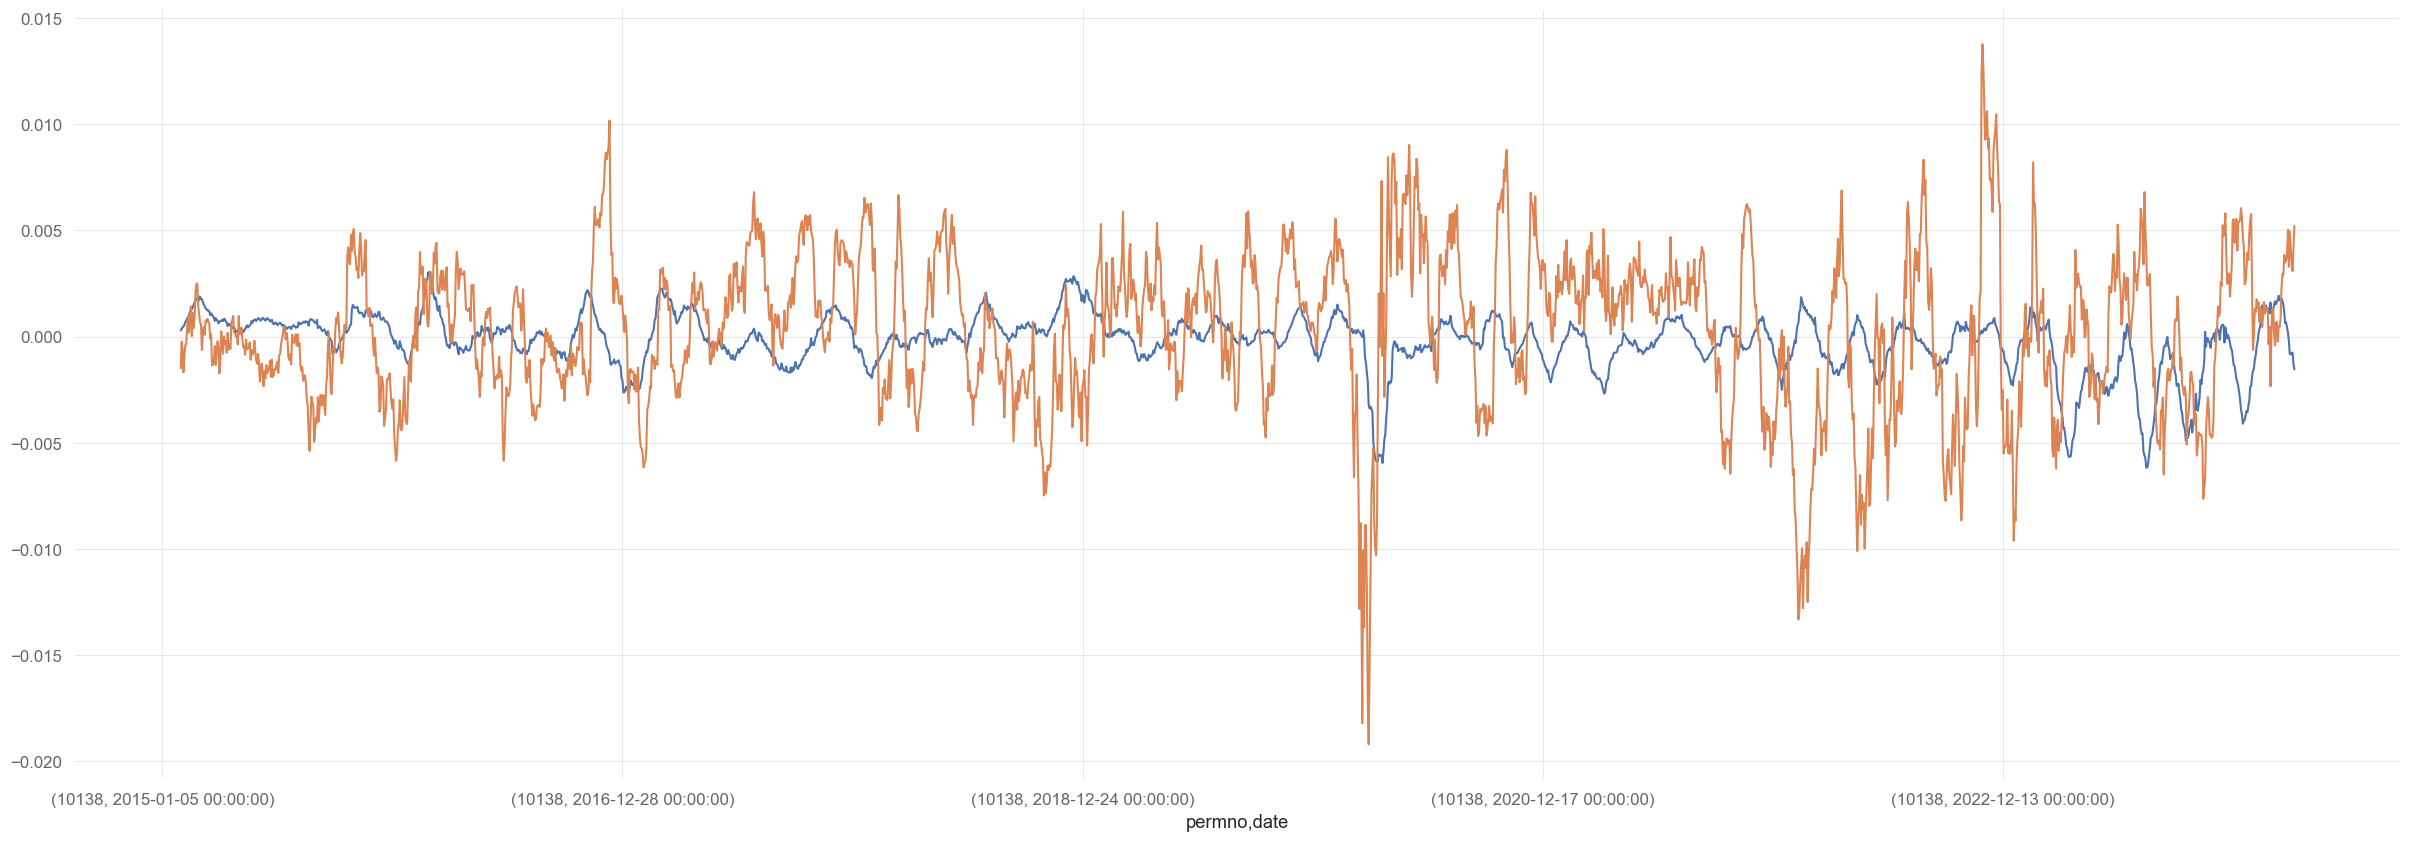

In [374]:
get_stock_data(merged, 10138).predictions.rolling(21).mean().plot(figsize=(30,10))
get_stock_data(merged, 10138).returns.rolling(21).mean().plot(figsize=(30, 10))

# Backtest

In [410]:
%%time
pred_return = backtest(tic, num_stocks=20, threshold=2_000_000_000)

----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2015
----------------------------------------------
2016
----------------------------------------------
2016
----------------------------------------------
2016
----------------------------------------------
2016
----------------------------------------------
2016
----------------------------------------------
2016
----------------------------------------------
2016
------------

# Calculate Total Returns

## Long

In [411]:
#Get SPY returns (matching timeframe as our backtest)
spy_return = get_spy(start_date=pred_return.index[0]-timedelta(days=1), end_date=pred_return.index[-1]+timedelta(days=1))
spy = spy_return['spyRet']

[*********************100%%**********************]  1 of 1 completed


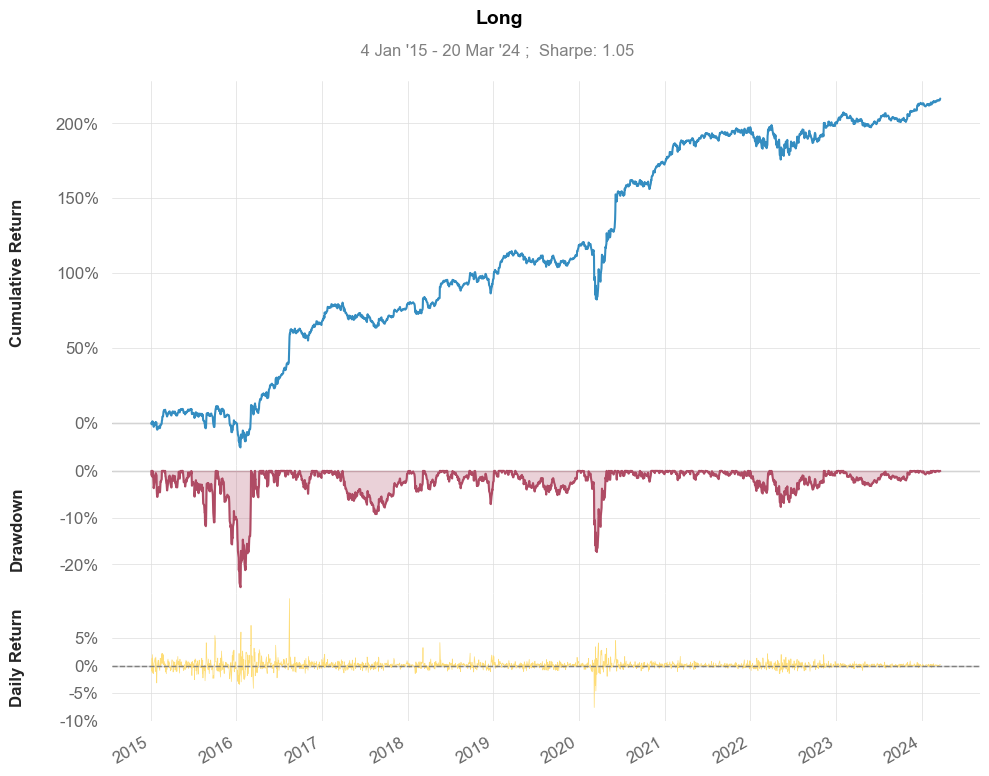

In [412]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='long', leverage=0.5)
long = pred_return_opt['totalRet']
# qs.reports.metrics(mode='basic', returns=stock, benchmark=spy, title='Long', fig_size=(10, 10))
qs.plots.snapshot(mode='basic', returns=long, benchmark=spy, title='Long', fig_size=(10, 10))

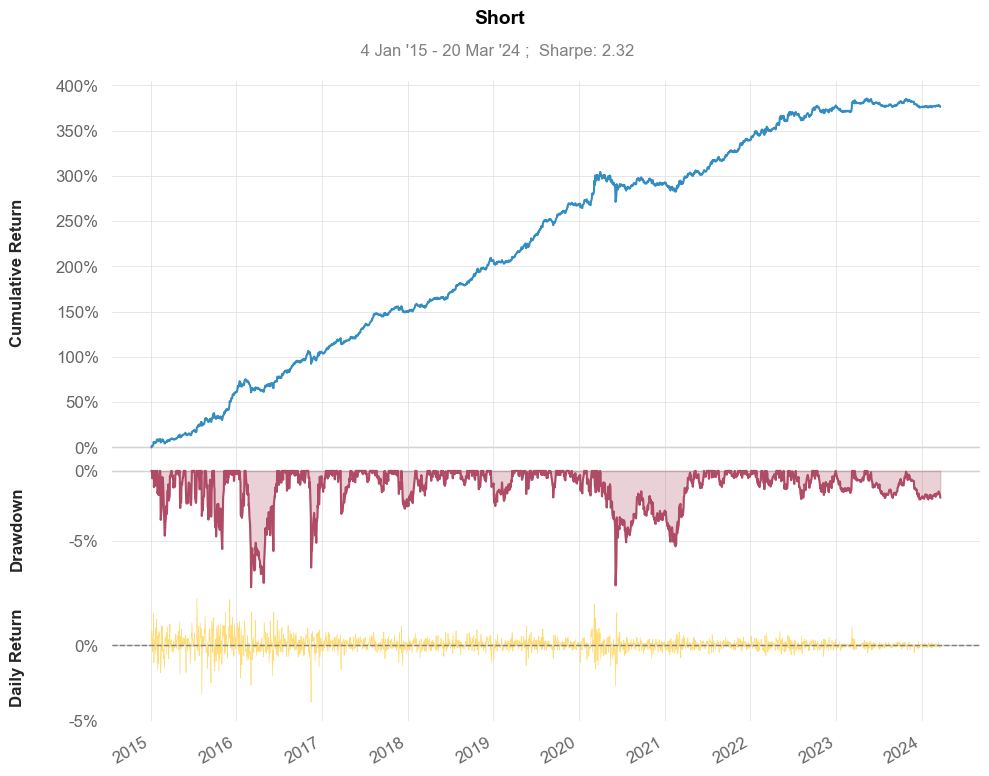

In [413]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='short', leverage=0.5)
short = pred_return_opt['totalRet']
# qs.reports.metrics(mode='basic', returns=stock, benchmark=spy, title='Short', fig_size=(10, 10))
qs.plots.snapshot(mode='basic', returns=short, benchmark=spy, title='Short', fig_size=(10, 10))

In [414]:
long.corr(short)

-0.5599095143810962

## Both

In [415]:
data = pred_return.copy(deep=True)

#### EWP

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  -----------
Start Period               2015-01-06   2015-01-06
End Period                 2024-03-20   2024-03-20
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          158.02%      30,035.31%
CAGR﹪                     7.37%        53.42%

Sharpe                     0.66         3.4
Prob. Sharpe Ratio         97.62%       100.0%
Smart Sharpe               0.63         3.24
Sortino                    0.92         6.19
Smart Sortino              0.88         5.89
Sortino/√2                 0.65         4.38
Smart Sortino/√2           0.62         4.17
Omega                      1.88         1.88

Max Drawdown               -34.1%       -13.56%
Longest DD Days            745          147
Volatility (ann.)          18.04%       18.78%
R^2                        0.0          0.0
Information Ratio          0.13         0.13
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-04,2020-03-13,2020-03-24,21,-13.558840,-12.445243
2,2016-11-10,2016-11-15,2016-12-08,29,-11.718325,-10.001381
3,2017-03-16,2017-04-24,2017-06-06,83,-9.839169,-9.285851
4,2022-04-04,2022-04-20,2022-06-06,64,-8.176529,-7.673873
5,2020-09-21,2020-10-15,2020-11-10,51,-7.425701,-7.390324


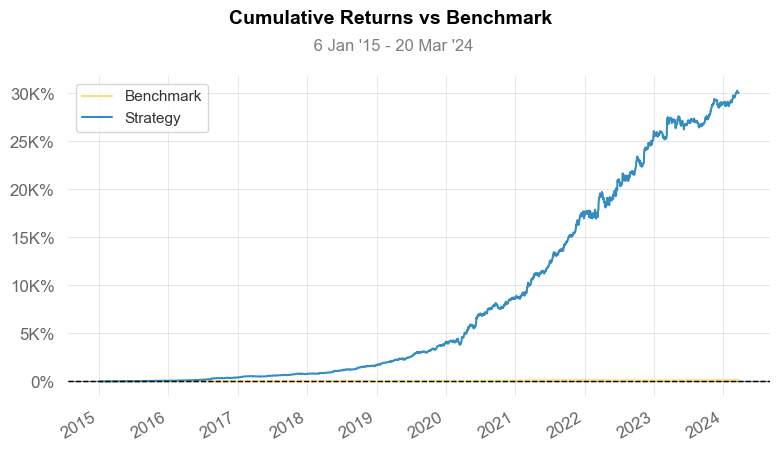

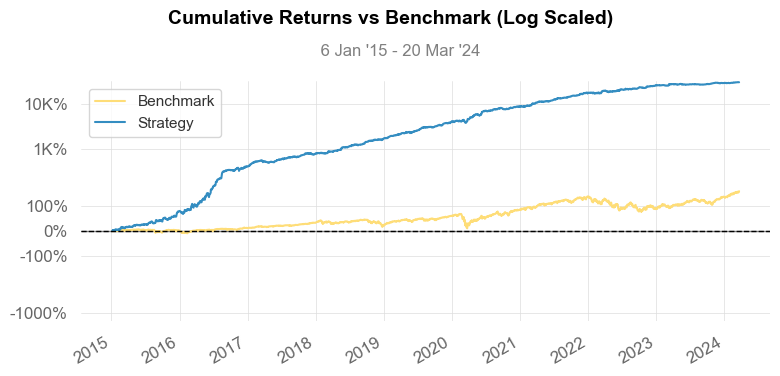

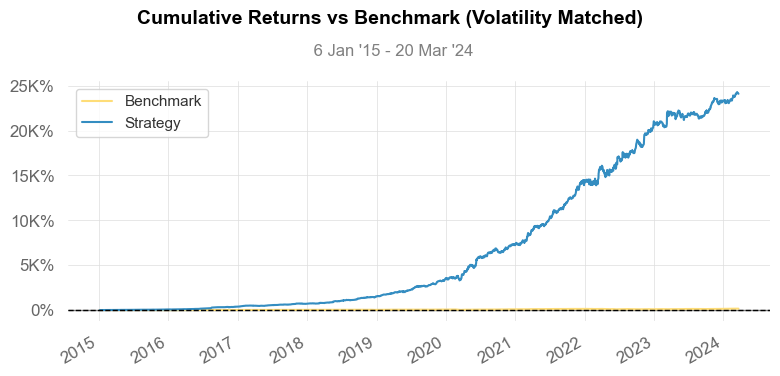

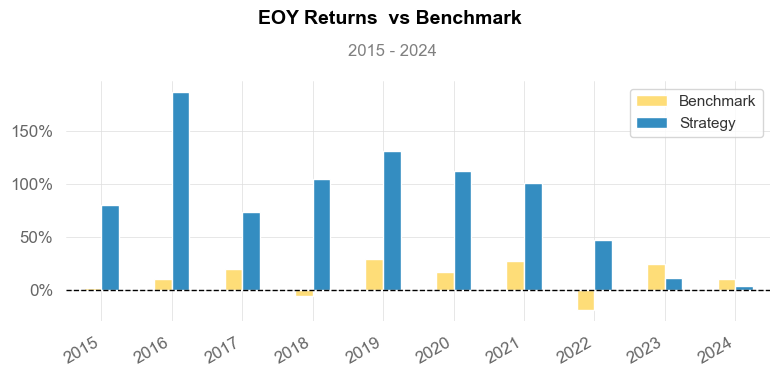

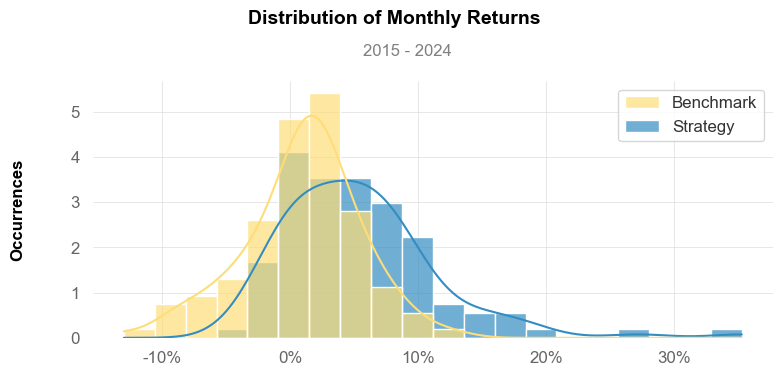

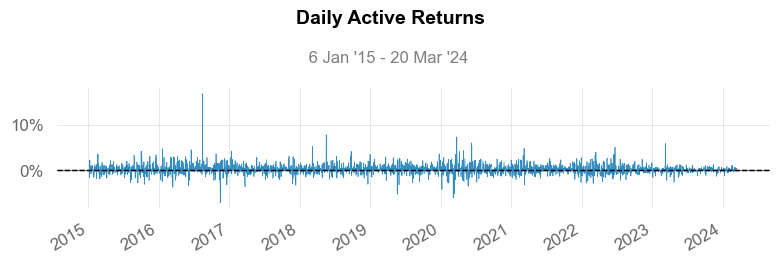

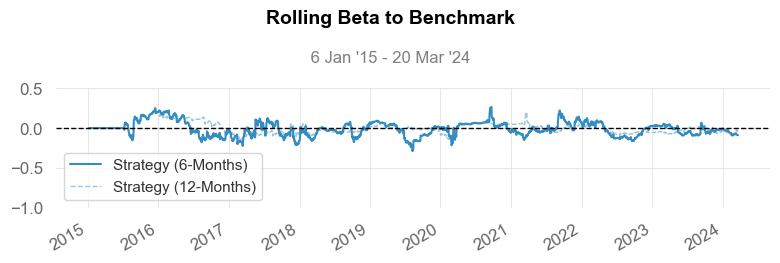

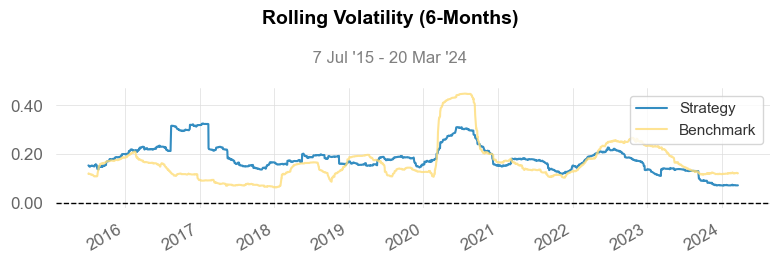

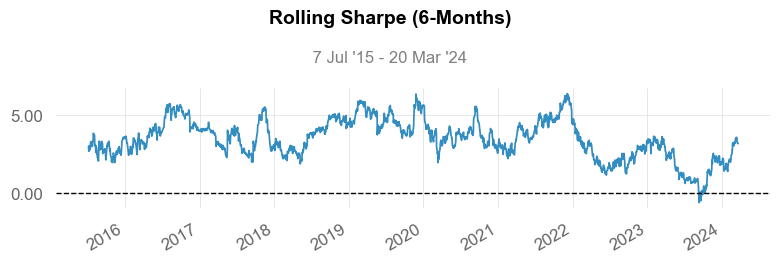

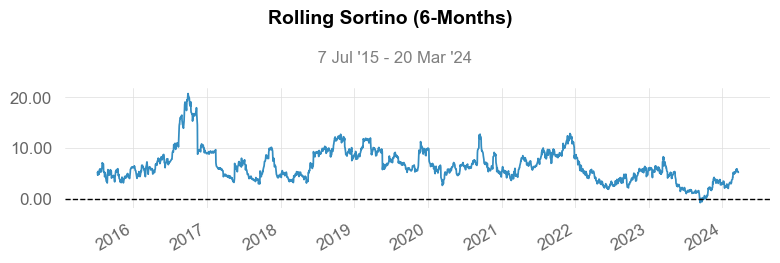

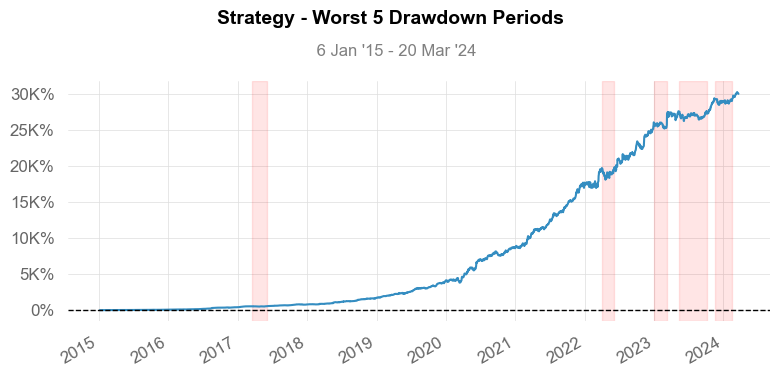

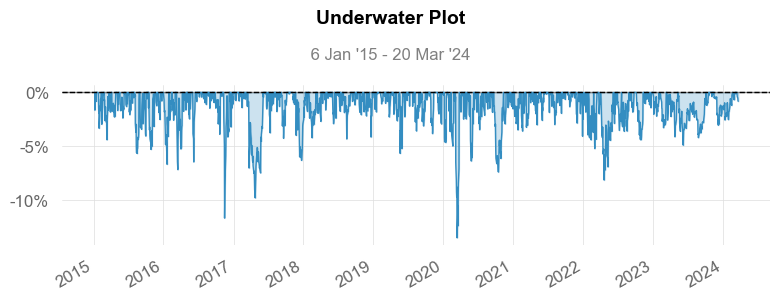

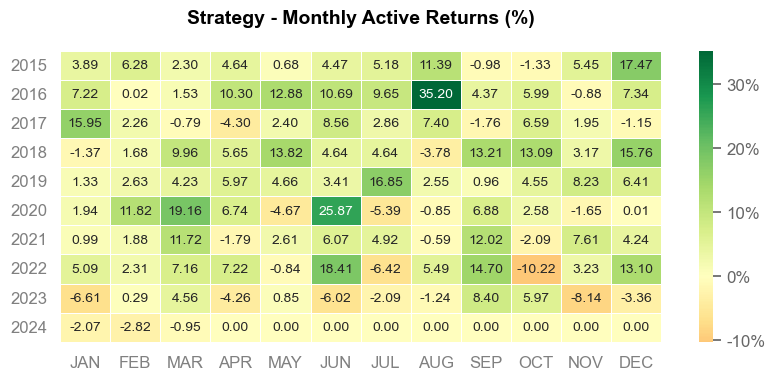

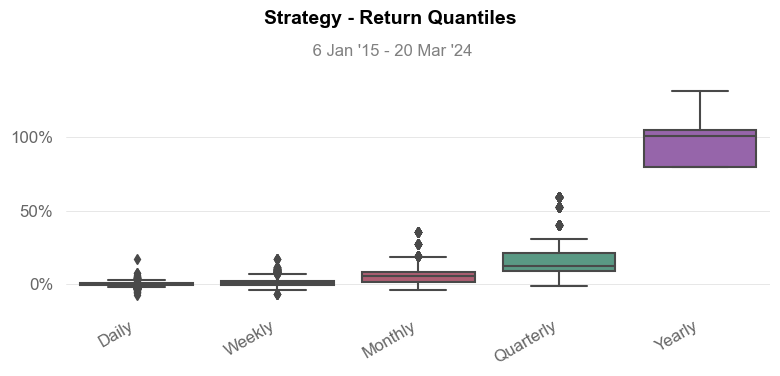

In [416]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='both', leverage=0.5)
stock = pred_return_opt['totalRet']
qs.reports.full(stock, 'SPY')

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  -----------
Start Period               2015-01-06   2015-01-06
End Period                 2024-03-14   2024-03-14
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          155.28%      47,006.12%
CAGR﹪                     7.29%        58.77%

Sharpe                     0.66         3.71
Prob. Sharpe Ratio         97.51%       100.0%
Smart Sharpe               0.62         3.5
Sortino                    0.91         6.97
Smart Sortino              0.86         6.58
Sortino/√2                 0.65         4.93
Smart Sortino/√2           0.61         4.65
Omega                      1.98         1.98

Max Drawdown               -34.1%       -11.93%
Longest DD Days            745          112
Volatility (ann.)          18.05%       18.56%
R^2                        0.0          0.0
Information Ratio          0.14         0.14
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-28,2020-03-13,2020-03-23,25,-11.927473,-10.692118
2,2016-11-11,2016-11-15,2016-12-15,35,-11.552130,-10.128282
3,2022-04-04,2022-05-10,2022-06-21,79,-9.716359,-9.190301
4,2017-03-16,2017-03-23,2017-05-26,72,-7.416418,-6.386274
5,2017-09-08,2017-09-26,2017-10-26,49,-7.310864,-7.104065


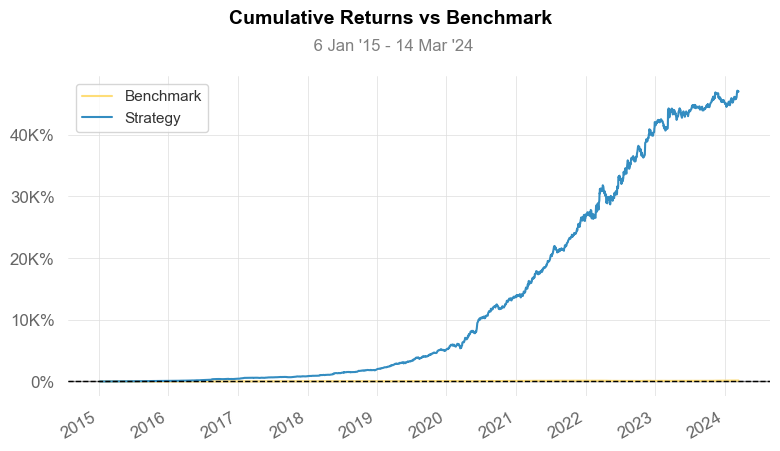

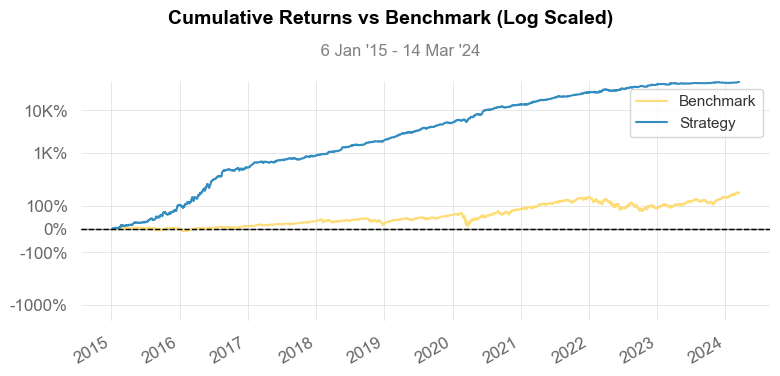

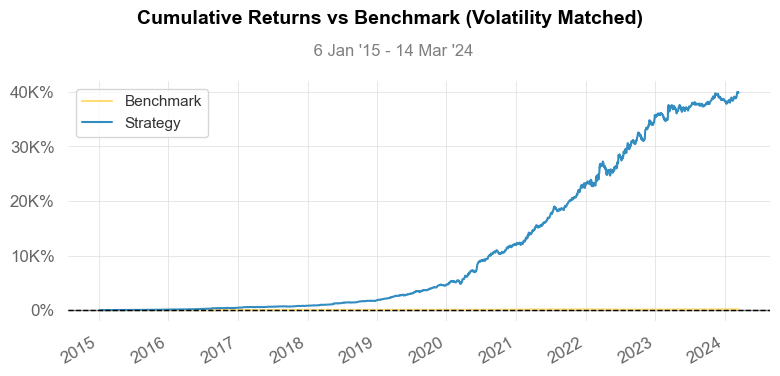

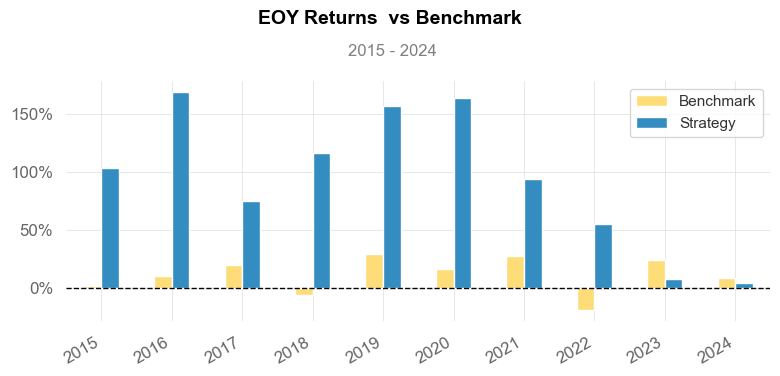

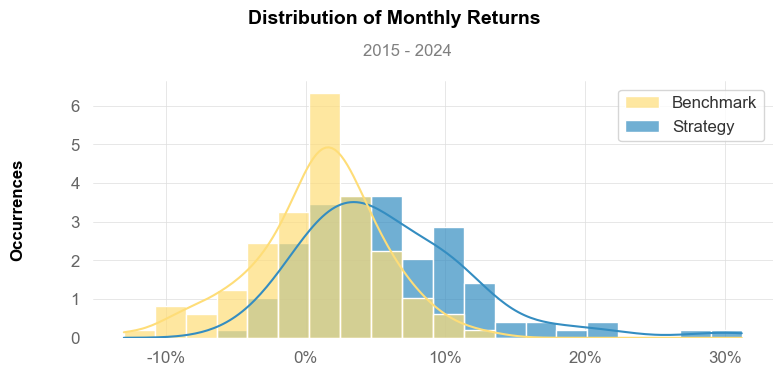

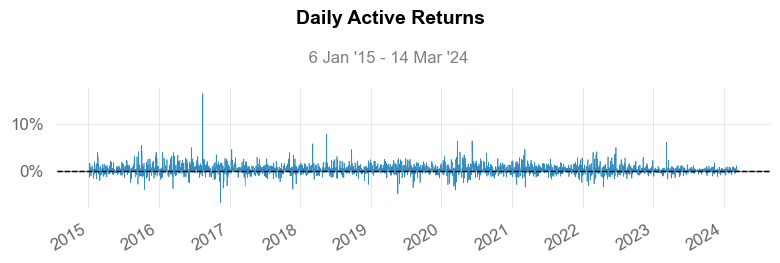

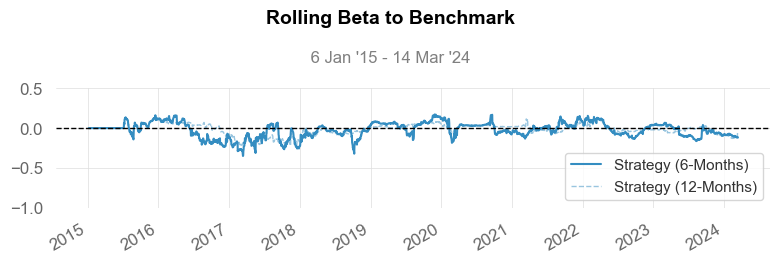

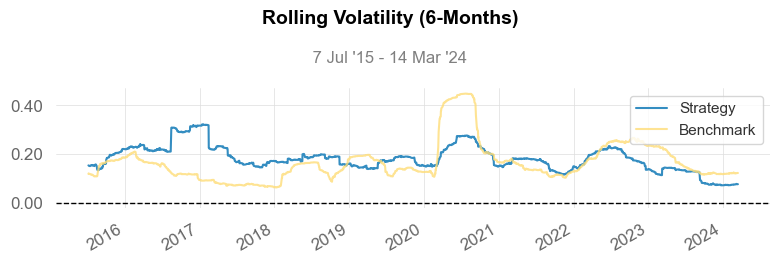

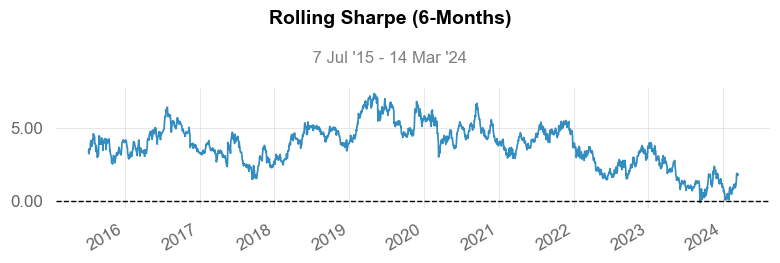

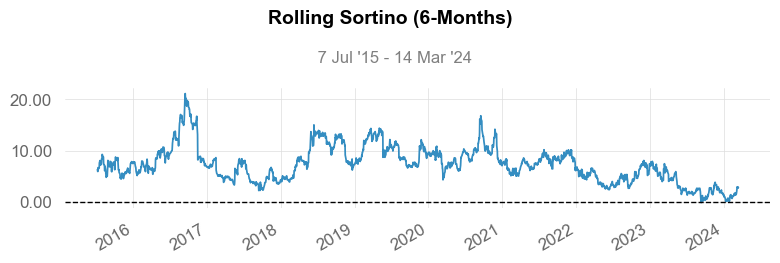

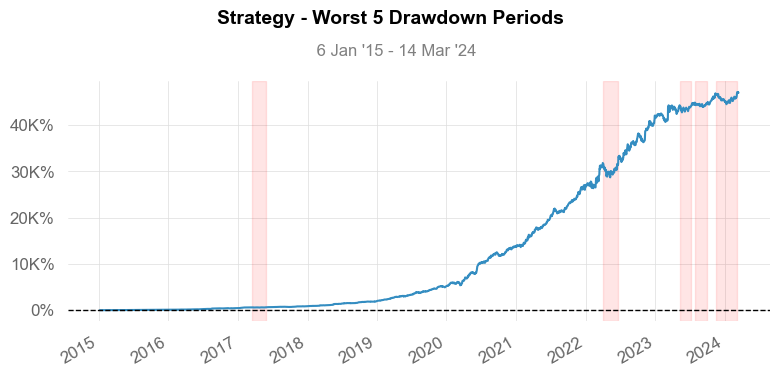

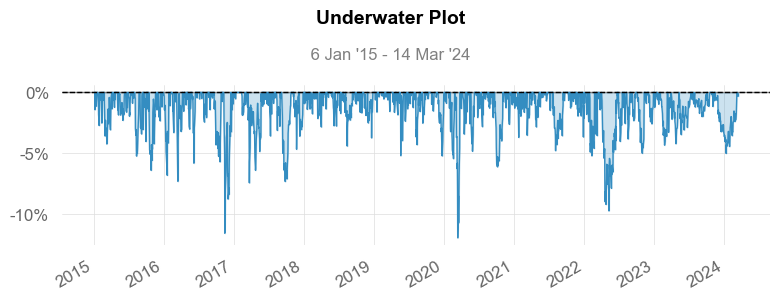

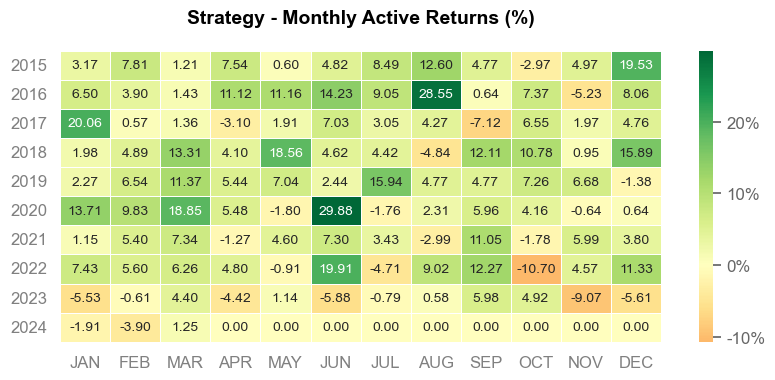

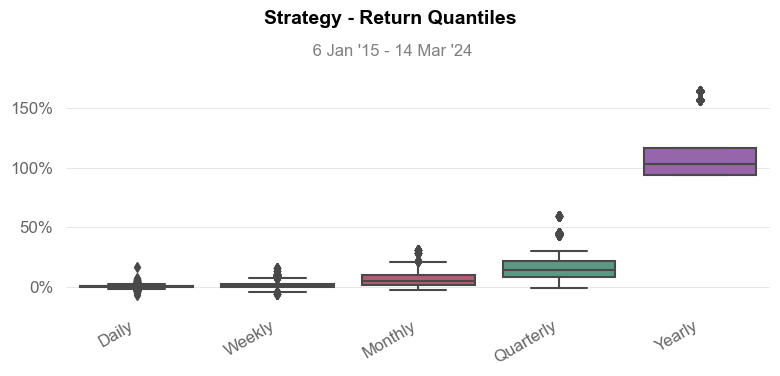

In [190]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='both', leverage=0.5)
stock = pred_return_opt['totalRet']
qs.reports.full(stock, 'SPY')

# Hedge against Bond Com

In [ ]:
# Commodities
trend_helper = TrendHelper(current_date='2024-01-23', start_date='2005-01-01', num_stocks=50)
com_ticker = ['GLD', 'SLV', 'PDBC', 'USO', 'AMLP', 'XOP', 'SHEL', 'CVX', 'SCCO', 'PXD']
com = trend_helper._get_ret(com_ticker)

# Bonds
bond_ticker = ['MBB', 'GOVT', 'VGSH', 'IUSB', 'TIP']

bond = trend_helper._get_ret(bond_ticker)

In [ ]:
# Create portfolio
bond_com_port = pd.concat([bond, com], axis=0)
bond_com_port['vol'] = bond_com_port.groupby('ticker')['RET_01'].transform(lambda x: x.rolling(5).std().shift(1))
bond_com_port['inv_vol'] = 1 / bond_com_port['vol']
bond_com_port['norm_inv_vol'] = bond_com_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
bond_com_port['RET_01'] = bond_com_port['RET_01'].groupby('ticker').shift(-1)
bond_com_port['weighted_ret'] = bond_com_port['RET_01'] * bond_com_port['norm_inv_vol']
bond_com_port = bond_com_port.groupby('date')['weighted_ret'].sum()
bond_com_port = bond_com_port.to_frame()
bond_com_port.columns = ['bond_comm_ret']

# Date Index
date_index = bond_com_port.index
date_index = date_index.to_frame().drop('date', axis=1).reset_index()

In [ ]:
bond_com_port.cumsum().plot()

In [106]:
with open(get_config() / 'api_key.json') as f:
    config = json.load(f)
    fred_key = config['fred_key']

# 10-Year Inflation Rate
fred = Fred(api_key=fred_key)
inflation = fred.get_series("T10YIE").to_frame()
inflation.columns = ['10YIF']
inflation = inflation.shift(1)
inflation = inflation.reset_index()
inflation = pd.merge_asof(date_index, inflation, left_on='date', right_on='index', direction='backward')
inflation = inflation.set_index('date').drop('index', axis=1)
inflation = inflation.ffill()

# 5-Year Market Yield
fred = Fred(api_key=fred_key)
unemploy = fred.get_series("DFII5").to_frame()
unemploy.columns = ['DF']
unemploy = unemploy.shift(1)
unemploy = unemploy.reset_index()
unemploy = pd.merge_asof(date_index, unemploy, left_on='date', right_on='index', direction='backward')
unemploy = unemploy.set_index('date').drop('index', axis=1)
unemploy = unemploy.ffill()

# 10-year vs. 3-month Yield Curve
fred = Fred(api_key=fred_key)
yield_curve = fred.get_series("T10Y3M").to_frame()
yield_curve.columns = ['YIELD']
yield_curve = yield_curve.shift(1)
yield_curve = yield_curve.reset_index()
yield_curve = pd.merge_asof(date_index, yield_curve, left_on='date', right_on='index', direction='backward')
yield_curve = yield_curve.set_index('date').drop('index', axis=1)
yield_curve = yield_curve.ffill()

# Macro Trend
macro = pd.concat([inflation, unemploy, yield_curve], axis=1)
macro['10YIF_z'] = (macro['10YIF'] - macro['10YIF'].mean()) / macro['10YIF'].std()
macro['DF_z'] = (macro['DF'] - macro['DF'].mean()) / macro['DF'].std()
macro['YIELD_z'] = (macro['YIELD'] - macro['YIELD'].mean()) / macro['YIELD'].std()
macro['mt'] = macro[['10YIF_z', 'DF_z', 'YIELD_z']].mean(axis=1)

for t in [21, 60]:
    macro[f'mt_{t}'] = macro['mt'].rolling(t).mean()

macro_buy = (macro['mt_21'] > macro['mt_60'])
macro_buy_df = macro_buy.to_frame()
macro_buy_df.columns = ['macro_buy']

In [107]:
# Combine trend portfolio + hedge portfolio
total_ret = pd.merge(stock.to_frame('ml_trend'), bond_com_port, left_index=True, right_index=True, how='left')
total_ret = total_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = total_ret.columns[0], total_ret.columns[1]

def _calc_total_port(row, col1, col2):
    if row['macro_buy']:
        return 0.50 * row[col1] + 0.50 * row[col2]
    else:
        return 0.25 * row[col1] + 0.75 * row[col2]
        
total_ret['total_ret'] = total_ret.apply(_calc_total_port, args=(col1, col2), axis=1)
total_daily_ret = total_ret['total_ret']

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  -----------
Start Period               2015-01-06   2015-01-06
End Period                 2024-01-22   2024-01-22
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          139.66%      1,012.09%
CAGR﹪                     6.9%         20.18%

Sharpe                     0.62         2.41
Prob. Sharpe Ratio         96.81%       100.0%
Smart Sharpe               0.62         2.4
Sortino                    0.87         4.47
Smart Sortino              0.87         4.46
Sortino/√2                 0.61         3.16
Smart Sortino/√2           0.61         3.16
Omega                      1.61         1.61

Max Drawdown               -34.1%       -11.14%
Longest DD Days            745          331
Volatility (ann.)          18.13%       11.35%
R^2                        0.0          0.0
Information Ratio          0.05         0.05
Calmar           

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-13,2020-03-17,2020-04-21,69,-11.143168,-10.377612
2,2017-10-04,2017-12-04,2018-04-30,209,-9.482870,-8.941464
3,2022-05-04,2022-07-11,2023-03-30,331,-8.211723,-8.092031
4,2020-11-12,2020-12-24,2021-02-05,86,-8.159769,-8.000626
5,2015-02-27,2015-06-09,2015-07-17,141,-6.130410,-6.009495


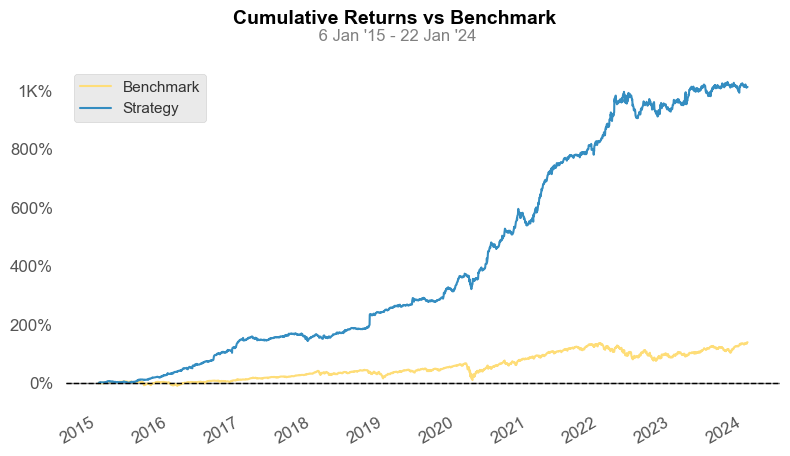

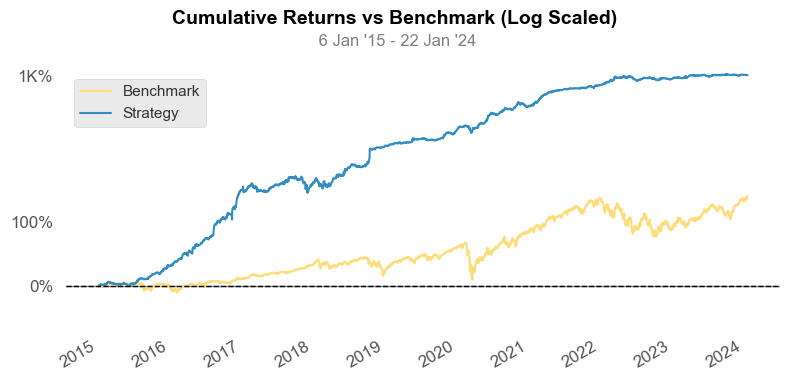

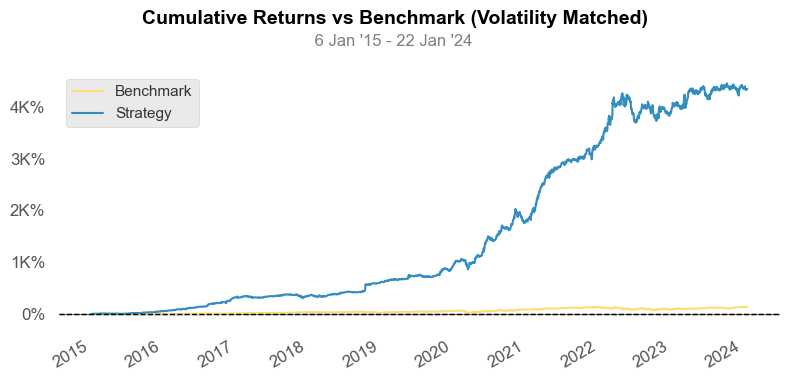

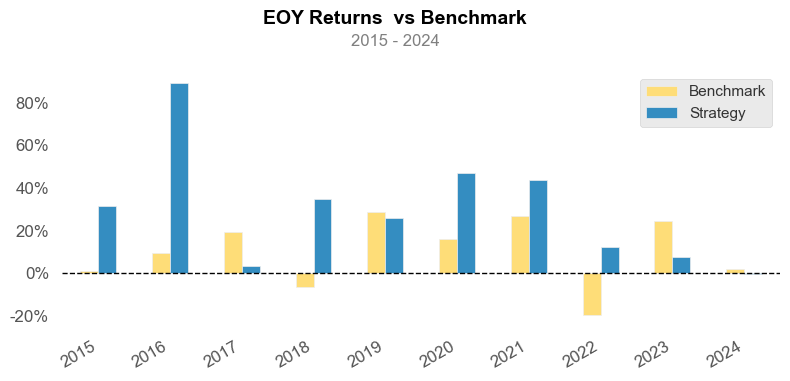

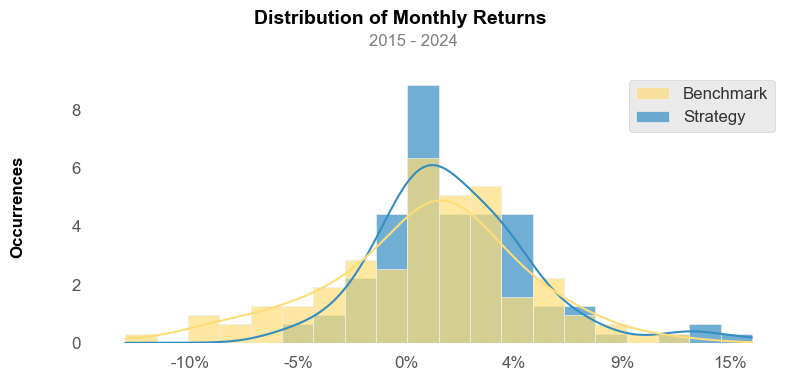

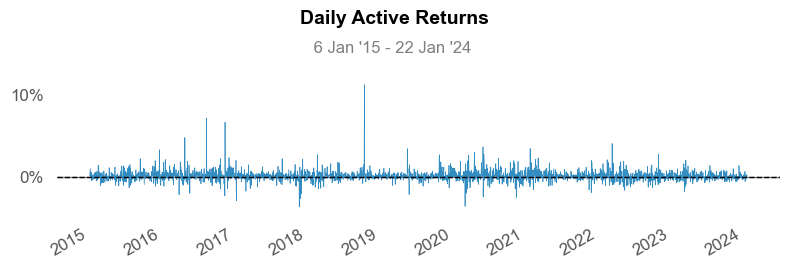

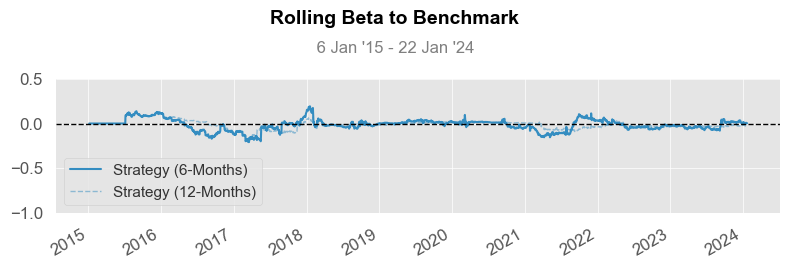

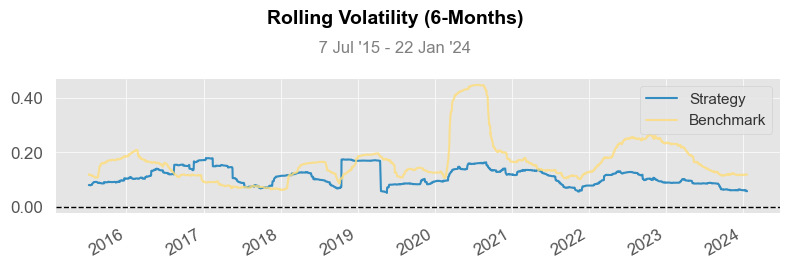

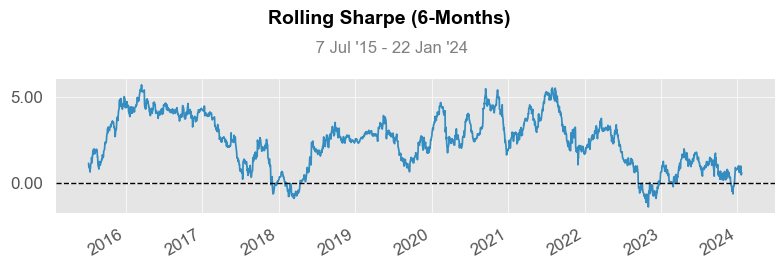

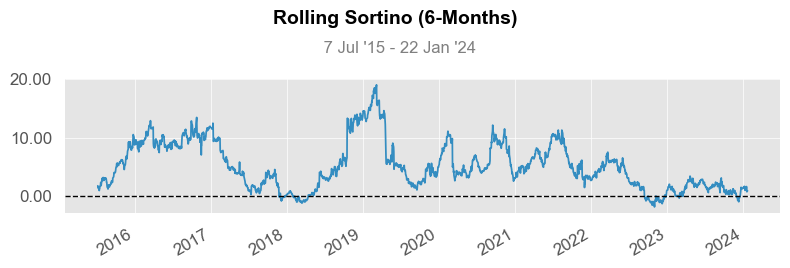

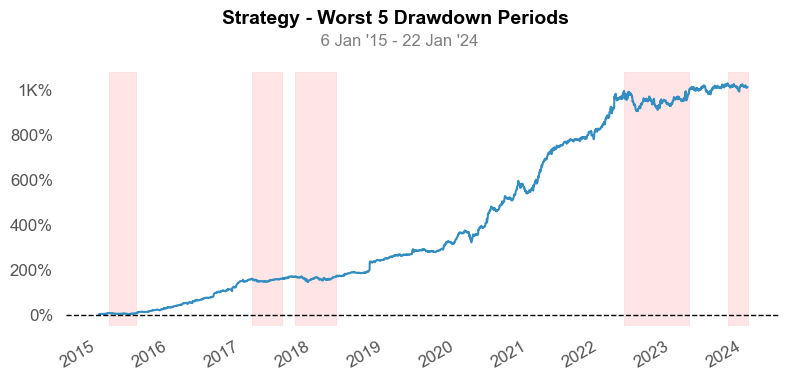

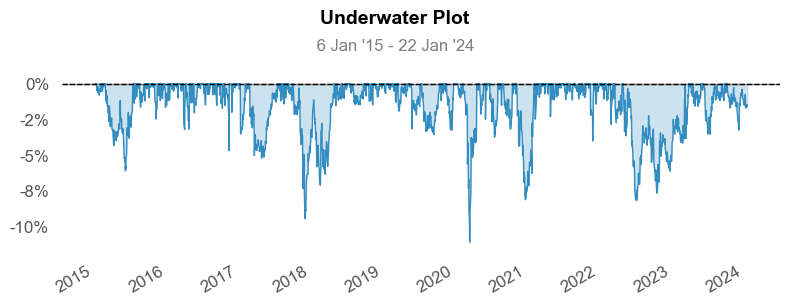

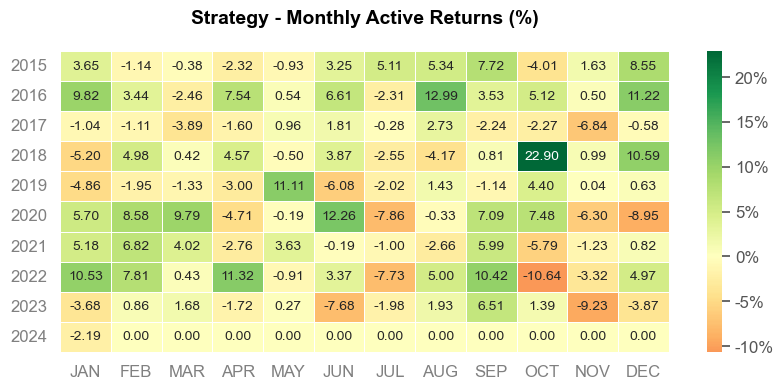

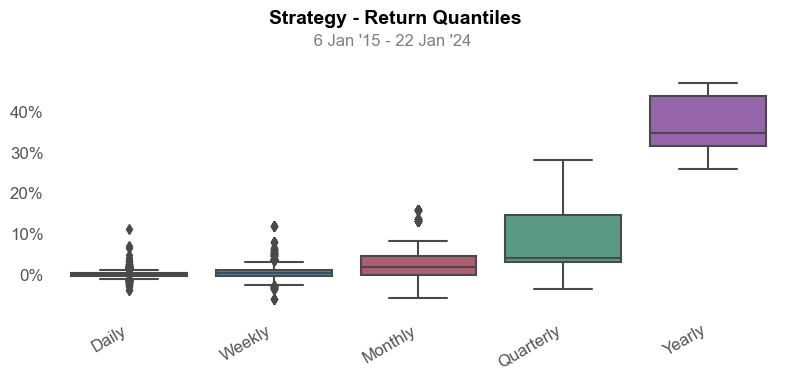

In [108]:
qs.reports.full(total_daily_ret, 'SPY')